### 1. Load Libraries

In [38]:
#libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Load source files
All devices that end with L- 
and 
State = In Use

In [39]:
pwd = os.getcwd()
df = pd.read_csv(pwd + '\\Source data\\alm_hardware.csv', encoding='ISO-8859-1')
# Extracting the userid value
df['assigned_to.u_ad_distinguished_name'] = df['assigned_to.u_ad_distinguished_name'].str.extract(r'CN=(.*?),')
df.rename(columns={'assigned_to.u_ad_distinguished_name': 'assigned_to_user'}, inplace=True)

# Load source data
lansweeper = pd.read_excel(pwd+ '\\Source Data\lansweeper.xlsx')
lansweeper.rename(columns={'AssetName': 'DeviceName'}, inplace=True)
lansweeper['DeviceName'] = lansweeper['DeviceName'].str.lower()
# Sort by Lastseen in descending order
lansweeper = lansweeper.sort_values(by='Lastseen', ascending=False)
# Drop duplicates based on DeviceName and Username, keeping the first occurrence
lansweeper = lansweeper.drop_duplicates(subset=['DeviceName', 'Username'], keep='first')

# Load SCCM Data into a DataFrame
sccm = pd.read_csv(pwd+ '\\Source Data\sccm.csv')
# Apply transformations
# convert entire df to lowercase
sccm = sccm.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# replace occurrences of unimelb\ and student\ with nothing
sccm.replace(to_replace=[r'unimelb\\', r'student\\'], value='', regex=True, inplace=True)
# rename ci column to DeviceName
sccm.rename(columns={'ci': 'DeviceName'}, inplace=True)
sccm = sccm.sort_values(by='lastlogon_datetime', ascending=False)
# Drop duplicates based on DeviceName and Username, keeping the first occurrence
sccm = sccm.drop_duplicates(subset=['DeviceName'], keep='first')

# Load AD user data to DataFrame 
jamf = pd.read_excel(pwd + '\\Source data\\jamf.xlsx')
jamf.rename(columns={'Computer Name': 'DeviceName'}, inplace=True)
jamf.rename(columns={'[ Status ] Primary User': 'PrimaryUser'}, inplace=True)
jamf.rename(columns={'[ Reporting ] Last Login User Account': 'LastLoginUser'}, inplace=True)
jamf.rename(columns={'[ Reporting ] Last Login User Date & Time': 'LastLoginTime'}, inplace=True)
jamf.loc[jamf['PrimaryUser'].isin(['Invalid', 'invalid']), 'PrimaryUser'] = ''
jamf = jamf.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# Load AD user data to DataFrame 
user_data = pd.read_csv(pwd + '\\Source data\\adusers.csv')


splunk = pd.read_csv(pwd + '\\Source data\\splunk.csv')
splunk.rename(columns={'host': 'DeviceName'}, inplace=True)
splunk['DeviceName'] = splunk['DeviceName'].str.lower()
splunk['prim_user'] = splunk['prim_user'].str.lower()
splunk['last_user'] = splunk['last_user'].str.lower()
splunk = splunk.drop_duplicates(subset=['DeviceName'], keep='first')


In [40]:
splunk.head()

DeviceName                     model manufacturer  chassis    serial  \
0   9520l-004727-l             Latitude 5320    Dell Inc.   laptop   CBBJHG3   
1   2200l-154784-l  ThinkPad T490 20N3S22100       LENOVO   laptop  PF21D96N   
2  640dlul19266121         OptiPlex 7460 AIO    Dell Inc.  desktop   9R69BS2   
3   6200l-153478-l  ThinkPad T490 20N3S22100       LENOVO   laptop  PF1YCR18   
4   4360l-149691-l  ThinkPad T480 20L6SAHA00       LENOVO   laptop  PF1QQEYD   

       os  os_ver  os_prel  os_arch                               sysuuid  \
0  Ubuntu   20.04      6.0       64  44454C4C-4200-1042-804A-C3C04F484733   
1  Ubuntu   20.04      6.0       64  CC93315E-561F-B211-A85C-A142627121CA   
2  Ubuntu   20.04      6.0       64  44454C4C-5200-1036-8039-B9C04F425332   
3  Ubuntu   20.04      6.0       64  CC7329DA-0A30-B211-A85C-B476500B34B8   
4  Ubuntu   20.04      6.0       64  4CD0452B-2B2A-B211-A85C-917CF59AF9F1   

   ...                                     fqdn                   domain  \
0  ...   9520l-004727-l.mobility.unimelb.net.au  mobility.unimelb.net.au   
1  ...   2200l-154784-l.mobility.unimelb.net.au  mobility.unimelb.net.au   
2  ...  640dlul19266121.mobility.unimelb.net.au  mobility.unimelb.net.au   
3  ...   6200l-153478-l.mobility.unimelb.net.au  mobility.unimelb.net.au   
4  ...   4360l-149691-l.mobility.unimelb.net.au  mobility.unimelb.net.au   

  dep_code  prim_user  last_user  last_user_date  build_date         conftool  \
0   9520.0     jhhali     jhhali      2023-08-21  06-01-2022   Ansible 2.12.8   
1   2200.0     iflint     iflint      2023-08-11  18-08-2022  Ansible 2.12.10   
2    640.0        NaN   daperera      2023-08-31  21-02-2022  Ansible 2.12.10   
3   6200.0      knapp      knapp      2023-08-31  30-10-2021   Ansible 2.12.9   
4   4360.0   zshireen   zshireen      2023-08-31  28-06-2022  Ansible 2.12.10   

  sysinfo_ver             sys_exec  
0         4.1  2023-08-31 12:00:09  
1         4.1  2023-08-31 12:00:09  
2         4.1  2023-08-31 12:00:05  
3         4.1  2023-08-31 12:00:09  
4         4.1  2023-08-31 12:00:09  

[5 rows x 43 columns]

### 3. Split into Windows, Mac and Linux devices and discard the rest

In [41]:
filtered_df = df[df['ci'].str.contains('-[mwl]$', case=False, na=False, regex=True)]
filtered_df = df[df['ci'].str.contains('-[mwl]$', case=False, na=False, regex=True)].copy()
filtered_df['ci'] = filtered_df['ci'].str.lower()

# Assuming filtered_df is already defined

# Filter rows where 'ci' values end with '-m'
df_m = filtered_df[filtered_df['ci'].str.endswith('-m')].copy()
df_m.rename(columns={'ci': 'DeviceName'}, inplace=True)
df_m['DeviceName'] = df_m['DeviceName'].str.lower()

# Filter rows where 'ci' values end with '-w'
df_w = filtered_df[filtered_df['ci'].str.endswith('-w')].copy()
df_w.rename(columns={'ci': 'DeviceName'}, inplace=True)
df_w['DeviceName'] = df_w['DeviceName'].str.lower()

# Filter rows where 'ci' values end with '-l'
df_l = filtered_df[filtered_df['ci'].str.endswith('-l')].copy()
df_l.rename(columns={'ci': 'DeviceName'}, inplace=True)
df_l['DeviceName'] = df_l['DeviceName'].str.lower()

# Rows that don't match the criteria
remaining_df = df[~df['ci'].str.contains('-[mwl]$', case=False, na=False, regex=True)]

In [42]:
print("Total: ", len(df))
print("Non Standard devices: ", len(remaining_df))
print("Windows: ",len(df_w))
print("Mac : ", len(df_m))
print("Linux : " ,len(df_l))

Total:  16847
Non Standard devices:  96
Windows:  11514
Mac :  4974
Linux :  263


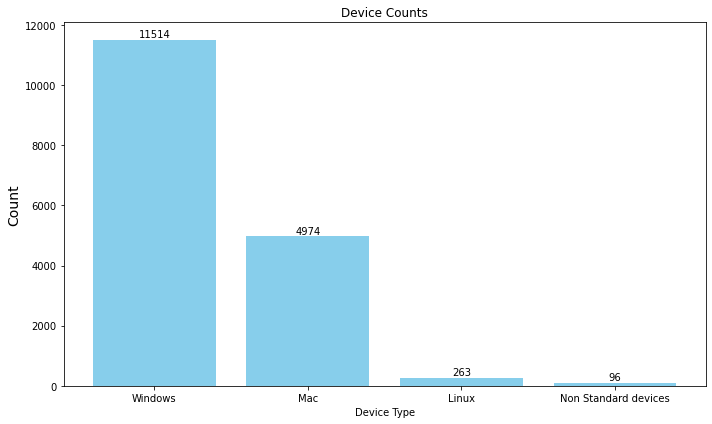

In [58]:
# Assuming the dataframes are already defined, we will calculate their lengths.
# Replace the lengths here with the actual lengths when running on real data.

data = {
    "Non Standard devices": len(remaining_df),
    "Windows": len(df_w),
    "Mac": len(df_m),
    "Linux": len(df_l)
}

# Sorting data in descending order
sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

# Extracting labels and values from sorted data
labels = list(sorted_data.keys())
values = list(sorted_data.values())

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color='skyblue')

plt.title('Device Counts')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Device Type')

# Adding labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Windows devices

### 4. Join columns 'TopConsoleUser_sccm', 'primary_user_sccm', 'lastlogon_username_sccm' to df_w

In [44]:
merged_df_w = df_w.merge(sccm[['DeviceName', 'TopConsoleUser_sccm', 'primary_user_sccm', 'lastlogon_username_sccm', 'lastlogon_datetime']],
                       on='DeviceName', how='left')
merged_df_w = merged_df_w.merge(user_data[['user', 'Manager userid']], left_on='assigned_to_user', right_on='user', how='left').drop(columns='user')
merged_df_w.loc[merged_df_w['TopConsoleUser_sccm'].str.contains(r'\\', na=False), 'TopConsoleUser_sccm'] = ''
merged_df_w.loc[merged_df_w['primary_user_sccm'].str.contains(r'\\', na=False), 'primary_user_sccm'] = ''
merged_df_w.rename(columns={'user': 'assigned_to_user'}, inplace=True)
merged_df_w.rename(columns={'Manager userid': 'manager_username'}, inplace=True)

TopConsoleUser_sccm_before = merged_df_w['TopConsoleUser_sccm'].count()
primary_user_sccm_before = merged_df_w['primary_user_sccm'].count()
lastlogon_username_sccm_before = merged_df_w['lastlogon_username_sccm'].count()
assigned_to_user_before = merged_df_w['assigned_to_user'].count()

merged_df_w1 = merged_df_w.copy()

# This block checks if a user is Inactive and sets the value as blank.

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_w where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace = merged_df_w['TopConsoleUser_sccm'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_w.loc[indices_to_replace, 'TopConsoleUser_sccm'] = np.nan

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping1 = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_w where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace1 = merged_df_w['primary_user_sccm'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_w.loc[indices_to_replace1, 'primary_user_sccm'] = np.nan

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping2 = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_w where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace2 = merged_df_w['lastlogon_username_sccm'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_w.loc[indices_to_replace2, 'lastlogon_username_sccm'] = np.nan

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_w where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace3 = merged_df_w['assigned_to_user'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_w.loc[indices_to_replace3, 'assigned_to_user'] = np.nan

TopConsoleUser_sccm_after = merged_df_w['TopConsoleUser_sccm'].count()
primary_user_sccm_after = merged_df_w['primary_user_sccm'].count()
lastlogon_username_sccm_after = merged_df_w['lastlogon_username_sccm'].count()
assigned_to_user_after = merged_df_w['assigned_to_user'].count()

# Compare
# Create a dictionary with the data
data = {
    'Before': [
        TopConsoleUser_sccm_before,
        primary_user_sccm_before,
        lastlogon_username_sccm_before,
        assigned_to_user_before
    ],
    'After': [
        TopConsoleUser_sccm_after,
        primary_user_sccm_after,
        lastlogon_username_sccm_after,
        assigned_to_user_after
    ]
}

# Create a DataFrame using the dictionary
compare = pd.DataFrame(data, index=['TopConsoleUser_sccm', 'primary_user_sccm', 'lastlogon_username_sccm', 'assigned_to_user'])
compare['dropped'] = compare['Before'] - compare['After']
compare

Before  After  dropped
TopConsoleUser_sccm        8529   8423      106
primary_user_sccm          8169   8044      125
lastlogon_username_sccm    8603   8514       89
assigned_to_user          11312  11169      143

### 5. Create a bucket function that classifies records based on whether the columns match or not 

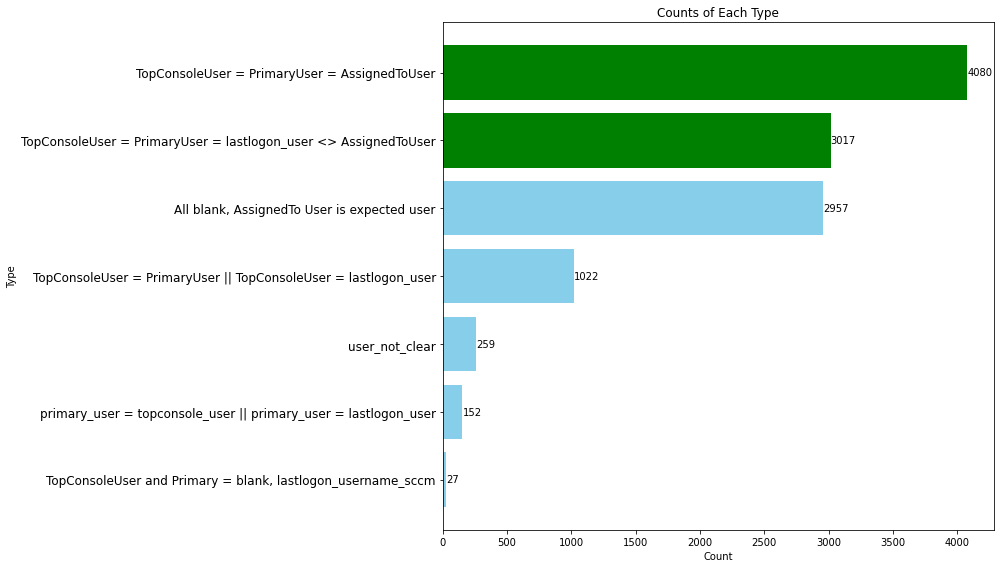

In [45]:
def user_bucket_function(row):
    assignedto_user = row['assigned_to_user']
    topconsole_user = row['TopConsoleUser_sccm']
    primary_user = row['primary_user_sccm']
    lastlogon_user = row['lastlogon_username_sccm']
    manager_user = row['manager_username']
    

    if assignedto_user == topconsole_user == primary_user:
        return assignedto_user, 'TopConsoleUser = PrimaryUser = AssignedToUser'
    
    if assignedto_user != primary_user and topconsole_user == primary_user == lastlogon_user :
        return primary_user, 'TopConsoleUser = PrimaryUser = lastlogon_user <> AssignedToUser'

    if pd.isna(topconsole_user) and pd.isna(primary_user) and pd.notna(lastlogon_user):
        return lastlogon_user, 'TopConsoleUser and Primary = blank, lastlogon_username_sccm'
    
    if pd.isna(topconsole_user) and pd.isna(primary_user) and pd.isna(lastlogon_user):
        return assignedto_user, 'All blank, AssignedTo User is expected user'

    if topconsole_user == primary_user or  topconsole_user == lastlogon_user :
        return topconsole_user, 'TopConsoleUser = PrimaryUser || TopConsoleUser = lastlogon_user'
    
    if primary_user == topconsole_user or  primary_user == lastlogon_user :
        return primary_user, 'primary_user = topconsole_user || primary_user = lastlogon_user'
    
    if lastlogon_user == topconsole_user or  lastlogon_user == primary_user :
        return lastlogon_user, 'lastlogon_user = topconsole_user || lastlogon_user = primary_user'
    
    return 'user_not_clear', 'user_not_clear'

# Apply the function
merged_df_w['expected user'], merged_df_w['type'] = zip(*merged_df_w.apply(user_bucket_function, axis=1))
distribution = merged_df_w['type'].value_counts()
# Count the occurrences of each type
type_counts = merged_df_w['type'].value_counts()

# Identify the top 1st and 3rd types by count
top_values = type_counts.nlargest(3).values[[0, 1]]

# Set colors based on whether each count is in the top_values
colors = ['green' if count in top_values else 'skyblue' for count in type_counts.values]

# Sort counts in ascending order for the barh plot
sorted_counts = type_counts.sort_values()

# Determine the sorted colors to match the sorted_counts order
sorted_colors = [colors[type_counts.index.get_loc(idx)] for idx in sorted_counts.index]

# Plot
plt.figure(figsize=(14, 8))
bars = plt.barh(sorted_counts.index, sorted_counts.values, color=sorted_colors)

plt.title('Counts of Each Type')
plt.ylabel('Type')
plt.xlabel('Count')
plt.tick_params(axis='y', labelsize=12)
# Adding labels next to each bar
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.3, bar.get_y() + bar.get_height()/2, int(xval), va='center', ha='left')

plt.tight_layout()
plt.show()

### 6. There are too many rows where SCCM has a blank record, join with lansweeper to see if those values exist and plot

C:\Users\shivak\AppData\Local\Temp/ipykernel_15880/1432196474.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['lansweeper_user'] = ''


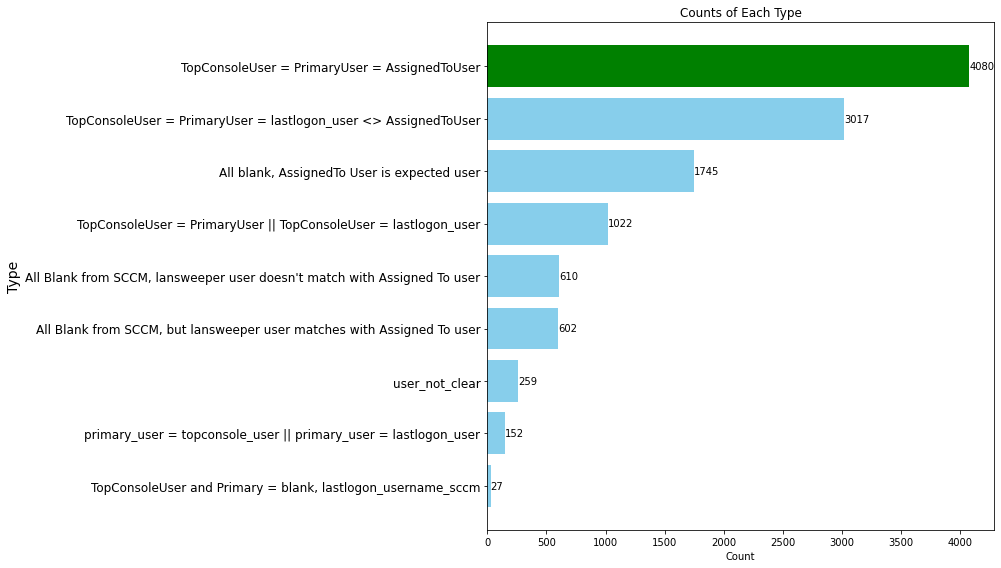

In [46]:
merged_df_w1 = merged_df_w.copy()
# create a subset df where Type = 'All blank, AssignedTo User is expected user'
filtered_df = merged_df_w1[merged_df_w1['type'] == 'All blank, AssignedTo User is expected user']
filtered_df1 = filtered_df.copy()
# create a subset df with remaining dfs
filtered_df2 = merged_df_w1[merged_df_w1['type'] != 'All blank, AssignedTo User is expected user']
filtered_df1 = filtered_df1.merge(lansweeper[['DeviceName', 'Username']], on='DeviceName', how='left')
filtered_df1.rename(columns={'Username': 'lansweeper_user'}, inplace=True)
filtered_df2['lansweeper_user'] = ''
filtered_df_lansweeper = filtered_df1.copy()
# Create a dataframe with rows where lansweeper_user is empty
df_empty = filtered_df_lansweeper[filtered_df_lansweeper['lansweeper_user'].isna()]
# Create a dataframe with rows where lansweeper_user is not empty
df_non_empty = filtered_df_lansweeper[~filtered_df_lansweeper['lansweeper_user'].isna()]

def user_bucket_function2(row):
    assignedto_user = row['assigned_to_user']
    topconsole_user = row['TopConsoleUser_sccm']
    primary_user = row['primary_user_sccm']
    lastlogon_user = row['lastlogon_username_sccm']
    manager_user = row['manager_username']
    lansweeper_user = row['lansweeper_user']
    
    if lansweeper_user == assignedto_user:
        return lansweeper_user, 'All Blank from SCCM, but lansweeper user matches with Assigned To user'
    
    if lansweeper_user != assignedto_user:
        return lansweeper_user, 'All Blank from SCCM, lansweeper user doesn\'t match with Assigned To user'
    
    return assignedto_user, 'All blank, AssignedTo User is expected user'

# Create a copy of the DataFrame
df_non_empty_copy = df_non_empty.copy()

# Apply the function on the copy
df_non_empty_copy['expected user'], df_non_empty_copy['type'] = zip(*df_non_empty_copy.apply(user_bucket_function2, axis=1))

# Concatenate the three dataframes
concatenated_df = pd.concat([df_non_empty_copy, df_empty, filtered_df2], ignore_index=True)
concatenated_df.to_csv(pwd+'\\Output\\windows_output.csv', index=False)
distribution = concatenated_df['type'].value_counts()

# Assuming merged_df_w is already defined and loaded with data

# Count the occurrences of each type
type_counts = concatenated_df['type'].value_counts()

# Identify the top 1st and 3rd types by count
top_values = type_counts.nlargest(3).values[[0]]

# Set colors based on whether each count is in the top_values
colors = ['green' if count in top_values else 'skyblue' for count in type_counts.values]

# Sort counts in ascending order for the barh plot
sorted_counts = type_counts.sort_values()

# Determine the sorted colors to match the sorted_counts order
sorted_colors = [colors[type_counts.index.get_loc(idx)] for idx in sorted_counts.index]

# Plot
plt.figure(figsize=(14, 8))
bars = plt.barh(sorted_counts.index, sorted_counts.values, color=sorted_colors)

plt.title('Counts of Each Type')
plt.ylabel('Type', fontsize = 14)
plt.xlabel('Count')

plt.tick_params(axis='y', labelsize=12)
# Adding labels next to each bar
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.3, bar.get_y() + bar.get_height()/2, int(xval), va='center', ha='left')

plt.tight_layout()
plt.show()

### For the ones we need to contact, 
sort by last online, if within last 2 months -> send survey <br>
if outside of last 2 months -> lock device

# Mac devices

In [47]:
merged_df_m = df_m.merge(jamf[['DeviceName', 'PrimaryUser', 'LastLoginUser', 'LastLoginTime']], on='DeviceName', how='left')
merged_df_m = merged_df_m.merge(user_data[['user', 'Manager userid']], left_on='assigned_to_user', right_on='user', how='left').drop(columns='user')
merged_df_m.rename(columns={'Manager userid': 'manager_username'}, inplace=True)

In [48]:
primary_user_jamf_before = merged_df_m['PrimaryUser'].count()
lastlogon_username_jamf_before = merged_df_m['LastLoginUser'].count()
assigned_to_user_before = merged_df_m['assigned_to_user'].count()

merged_df_m1 = merged_df_m.copy()

# This block checks if a user is Inactive and sets the value as blank.

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_m where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace = merged_df_m['PrimaryUser'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_m.loc[indices_to_replace, 'PrimaryUser'] = np.nan

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping1 = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_m where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace1 = merged_df_m['LastLoginUser'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_m.loc[indices_to_replace1, 'LastLoginUser'] = np.nan

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping2 = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_m where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace2 = merged_df_m['assigned_to_user'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_m.loc[indices_to_replace2, 'assigned_to_user'] = np.nan

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_m where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace3 = merged_df_m['assigned_to_user'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_m.loc[indices_to_replace3, 'assigned_to_user'] = np.nan
primary_user_jamf_after = merged_df_m['PrimaryUser'].count()
lastlogon_username_jamf_after = merged_df_m['LastLoginUser'].count()
assigned_to_user_after = merged_df_m['assigned_to_user'].count()
# Compare
# Create a dictionary with the data
data = {
    'Before': [
        primary_user_jamf_before,
        lastlogon_username_jamf_before,
        assigned_to_user_before
    ],
    'After': [
        primary_user_jamf_after,
        lastlogon_username_jamf_after,
        assigned_to_user_after
    ]
}

# Create a DataFrame using the dictionary
compare = pd.DataFrame(data, index=['PrimaryUser', 'LastLoginUser', 'assigned_to_user'])
compare['dropped'] = compare['Before'] - compare['After']
compare

Before  After  dropped
PrimaryUser         4542   4504       38
LastLoginUser       4550   4519       31
assigned_to_user    4975   4923       52

In [49]:
def user_bucket_function_mac(row):
    assignedto_user = row['assigned_to_user']
    primary_user = row['PrimaryUser']
    lastlogon_user = row['LastLoginUser']
    manager_user = row['manager_username']
    

    if assignedto_user == primary_user == lastlogon_user:
        return assignedto_user, 'assignedto_user = primary_user = lastlogon_user'
    
    if assignedto_user != primary_user and primary_user == lastlogon_user:
        return primary_user, 'PrimaryUser = lastlogon_user <> AssignedToUser'
    
    if pd.isna(primary_user) and pd.isna(lastlogon_user):
        return assignedto_user, 'All blank, AssignedTo User is expected user'

    if assignedto_user == primary_user or assignedto_user == lastlogon_user :
        return assignedto_user, 'assignedto_user = PrimaryUser || assignedto_user = lastlogon_user'
    
    if pd.isna(primary_user) and pd.notna(lastlogon_user):
        return lastlogon_user, 'primary user is blank, but lastlogon_user exists'
    
    if pd.isna(lastlogon_user) and pd.notna(primary_user):
        return primary_user, 'lastlogon_user user is blank, but primary_user exists'
    
    return 'manager_user', 'user_not_clear'

# Apply the function
merged_df_m['expected user'], merged_df_m['type'] = zip(*merged_df_m.apply(user_bucket_function_mac, axis=1))
distribution = merged_df_m['type'].value_counts()
merged_df_m.to_csv(pwd+'\\Output\\mac_output.csv', index=False)

In [50]:
distribution

assignedto_user = primary_user = lastlogon_user                      2838
PrimaryUser = lastlogon_user <> AssignedToUser                       1331
All blank, AssignedTo User is expected user                           369
assignedto_user = PrimaryUser || assignedto_user = lastlogon_user     292
user_not_clear                                                        102
primary user is blank, but lastlogon_user exists                       63
lastlogon_user user is blank, but primary_user exists                  23
Name: type, dtype: int64

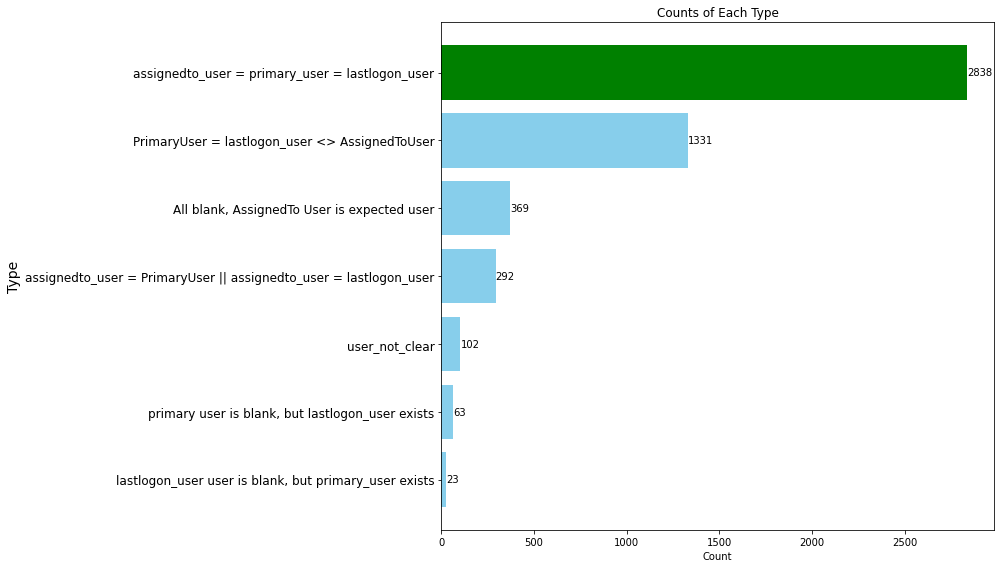

In [51]:
# Assuming merged_df_w is already defined and loaded with data

# Count the occurrences of each type
type_counts = merged_df_m['type'].value_counts()

# Identify the top 1st and 3rd types by count
top_values = type_counts.nlargest(3).values[[0]]

# Set colors based on whether each count is in the top_values
colors = ['green' if count in top_values else 'skyblue' for count in type_counts.values]

# Sort counts in ascending order for the barh plot
sorted_counts = type_counts.sort_values()

# Determine the sorted colors to match the sorted_counts order
sorted_colors = [colors[type_counts.index.get_loc(idx)] for idx in sorted_counts.index]

# Plot
plt.figure(figsize=(14, 8))
bars = plt.barh(sorted_counts.index, sorted_counts.values, color=sorted_colors)

plt.title('Counts of Each Type')
plt.ylabel('Type', fontsize = 14)
plt.xlabel('Count')

plt.tick_params(axis='y', labelsize=12)
# Adding labels next to each bar
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.3, bar.get_y() + bar.get_height()/2, int(xval), va='center', ha='left')

plt.tight_layout()
plt.show()

# Linux

In [52]:
# Assuming you already have df_l and splunk dataframes
merged_df_l = df_l.merge(splunk[['DeviceName', 'prim_user', 'last_user']], on='DeviceName', how='left')
merged_df_l = merged_df_l.merge(user_data[['user', 'Manager userid']], left_on='assigned_to_user', right_on='user', how='left').drop(columns='user')
merged_df_l.rename(columns={'Manager userid': 'manager_username'}, inplace=True)
merged_df_l.head()

asset_tag model_category                                   display_name  \
0       NaN       Computer  QEMU pc-q35-4.2 Standard PC (Q35 + ICH9, 2009   
1       NaN       Computer  QEMU pc-q35-4.2 Standard PC (Q35 + ICH9, 2009   
2       NaN       Computer  QEMU pc-q35-4.2 Standard PC (Q35 + ICH9, 2009   
3       NaN       Computer                            DELL Latitude E7240   
4       NaN       Computer                        Dell Inc. Latitude 5320   

  assigned_to  assigned_to.u_ad_samaccountname assigned_to_user  \
0         NaN                              NaN              NaN   
1         NaN                              NaN              NaN   
2         NaN                              NaN              NaN   
3   Kenny Jao                              NaN             jaok   
4         NaN                              NaN              NaN   

                                             company install_status substatus  \
0                                  Business Services         In use       NaN   
1                                  Business Services         In use       NaN   
2                                  Business Services         In use       NaN   
3  Florey Department of Neuroscience and Mental H...         In use       NaN   
4  Florey Department of Neuroscience and Mental H...         In use       NaN   

       DeviceName  ... pre_allocated purchase_date quantity  \
0  9870l-800723-l  ...         False    01/09/2021        1   
1  9870l-800732-l  ...         False    08/09/2021        1   
2  9870l-800738-l  ...         False    22/08/2021        1   
3  9520l-003310-l  ...         False    25/02/2023        1   
4  9520l-004694-l  ...         False    11/11/2021        1   

  u_replacement_status u_replacement_device_model  \
0         Not Eligible                        NaN   
1         Not Eligible                        NaN   
2         Not Eligible                        NaN   
3         Not Eligible                        NaN   
4         Not Eligible                        NaN   

                          serial_number  assigned_to.active  prim_user  \
0  kvm-1c1864861df540158a2f5cdf3db5835e               False        NaN   
1  kvm-cb229880e8bb4e4db170dd28a485ecd3               False        NaN   
2  kvm-634b53f4bcef495aa2dc36be7e851f52               False        NaN   
3                               9tt6k32                True       jaok   
4                               hbbjhg3               False     acapon   

  last_user manager_username  
0       NaN              NaN  
1       NaN              NaN  
2       NaN              NaN  
3      jaok         tennantm  
4    acapon              NaN  

[5 rows x 33 columns]

In [53]:
primary_user_splunk_before = merged_df_l['prim_user'].count()
lastlogon_username_splunk_before = merged_df_l['last_user'].count()
assigned_to_user_before = merged_df_l['assigned_to_user'].count()

merged_df_l1 = merged_df_l.copy()

# This block checks if a user is Inactive and sets the value as blank.

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_m where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace = merged_df_l['prim_user'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_l.loc[indices_to_replace, 'prim_user'] = np.nan

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping1 = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_m where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace1 = merged_df_l['last_user'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_l.loc[indices_to_replace1, 'last_user'] = np.nan

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping2 = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_m where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace2 = merged_df_l['assigned_to_user'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_l.loc[indices_to_replace2, 'assigned_to_user'] = np.nan

# Create a mapping from 'user' to 'AccountStatus'
account_status_mapping = user_data.set_index('user')['AccountStatus'].to_dict()
# Identify rows in merged_df_m where 'TopConsoleUser_sccm' has 'AccountStatus' as False
indices_to_replace3 = merged_df_l['assigned_to_user'].map(account_status_mapping) == False
# Replace those rows in 'TopConsoleUser_sccm' with NaN
merged_df_l.loc[indices_to_replace3, 'assigned_to_user'] = np.nan


primary_user_splunk_after = merged_df_l['prim_user'].count()
lastlogon_username_splunk_after = merged_df_l['last_user'].count()
assigned_to_user_after = merged_df_l['assigned_to_user'].count()

# Compare
# Create a dictionary with the data
data = {
    'Before': [
        primary_user_splunk_before,
        lastlogon_username_splunk_before,
        assigned_to_user_before
    ],
    'After': [
        primary_user_splunk_after,
        lastlogon_username_splunk_after,
        assigned_to_user_after
    ]
}

# Create a DataFrame using the dictionary
compare = pd.DataFrame(data, index=['prim_user', 'last_user', 'assigned_to_user'])
compare['dropped'] = compare['Before'] - compare['After']
compare

Before  After  dropped
prim_user             60     60        0
last_user             68     68        0
assigned_to_user     161    159        2

In [54]:
def user_bucket_function_linux(row):
    assignedto_user = row['assigned_to_user']
    primary_user = row['prim_user']
    lastlogon_user = row['last_user']
    manager_user = row['manager_username']
    

    if assignedto_user == primary_user == lastlogon_user:
        return assignedto_user, 'assignedto_user = primary_user = lastlogon_user'
    
    if assignedto_user != primary_user and primary_user == lastlogon_user:
        return primary_user, 'PrimaryUser = lastlogon_user <> AssignedToUser'
    
    if pd.isna(primary_user) and pd.isna(lastlogon_user):
        return assignedto_user, 'All blank, AssignedTo User is expected user'

#     if assignedto_user == primary_user or assignedto_user == lastlogon_user :
#         return assignedto_user, 'assignedto_user = PrimaryUser || assignedto_user = lastlogon_user'
    
#     if pd.isna(primary_user) and pd.notna(lastlogon_user):
#         return lastlogon_user, 'primary user is blank, but lastlogon_user exists'
    
#     if pd.isna(lastlogon_user) and pd.notna(primary_user):
#         return primary_user, 'lastlogon_user user is blank, but primary_user exists'
    
    return 'manager_user', 'user_not_clear'

# Apply the function
merged_df_l['expected user'], merged_df_l['type'] = zip(*merged_df_l.apply(user_bucket_function_linux, axis=1))
distribution = merged_df_l['type'].value_counts()
merged_df_l.to_csv(pwd+'\\Output\\linux_output.csv', index=False)

In [55]:
merged_df_l.shape

(263, 35)

In [56]:
distribution = merged_df_l['type'].value_counts()
distribution

All blank, AssignedTo User is expected user        195
assignedto_user = primary_user = lastlogon_user     30
PrimaryUser = lastlogon_user <> AssignedToUser      30
user_not_clear                                       8
Name: type, dtype: int64

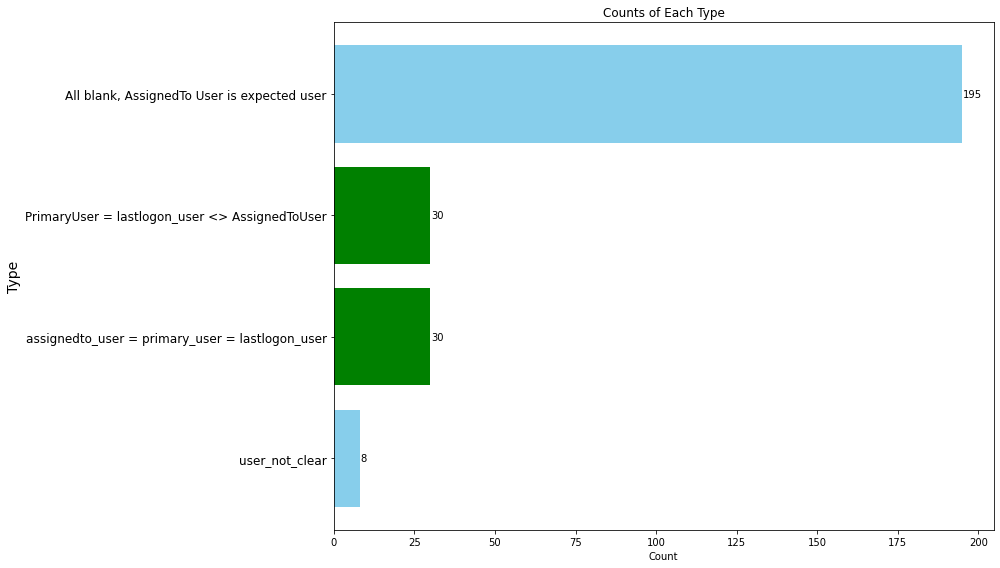

In [57]:
# Count the occurrences of each type
type_counts = merged_df_l['type'].value_counts()

# Identify the 1st and 3rd types by count
top_values = type_counts.nlargest(3).values[[2]]  # Fetch only the 3rd highest value

# Set colors based on whether each count is in the top_values
colors = ['green' if count in top_values else 'skyblue' for count in type_counts.values]

# Sort counts in ascending order for the barh plot
sorted_counts = type_counts.sort_values()

# Determine the sorted colors to match the sorted_counts order
sorted_colors = [colors[type_counts.index.get_loc(idx)] for idx in sorted_counts.index]

# Plot
plt.figure(figsize=(14, 8))
bars = plt.barh(sorted_counts.index, sorted_counts.values, color=sorted_colors)

plt.title('Counts of Each Type')
plt.ylabel('Type', fontsize = 14)
plt.xlabel('Count')

plt.tick_params(axis='y', labelsize=12)
# Adding labels next to each bar
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.3, bar.get_y() + bar.get_height()/2, int(xval), va='center', ha='left')

plt.tight_layout()
plt.show()
